## Importing the header files

In [33]:
import pandas as pd
import numpy as np
import random
import sys
import xgboost as xgb
from collections import Counter
from xgboost import plot_importance
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.utils import resample,shuffle
from sklearn import metrics
from sklearn.metrics import roc_curve, auc,f1_score,matthews_corrcoef,classification_report,balanced_accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
import matplotlib.pylab as plt
import eli5
from eli5.sklearn import PermutationImportance
%matplotlib inline

## Reading in the dataset

Reading in the dataset and looking at the class balance. Looking at the class balance, the dominant class is ~3 times the underrepresented class. 

In [34]:
df = pd.read_csv('df_dev.csv')
#df=df.dropna()
print(df.Default.value_counts())


df['card_type'] = df['card_type'].fillna(np.nan)
df_temp = df.copy(deep=True)
lbl = preprocessing.LabelEncoder()
df_temp['card_type'] = lbl.fit_transform(df['card_type'].astype(str))
df_final = df_temp.where(~df.isna(), df)
df_final['card_type'] = pd.to_numeric(df_final['card_type'])

'''
y = df_final.iloc[:,-1]
X =  df_final.loc[:, df.columns != 'Default']
X.head()
'''

#Stratify the 2 classes
df_nondefault = df_final[df_final.Default==0]
df_default = df_final[df_final.Default==1]

#Split the datasets into X and Y for both the classes

####Default Class############
y_default = df_default.iloc[:,-1]
X_default =  df_default.loc[:, df_default.columns != 'Default']
X_default_train,X_default_test,y_default_train,y_default_test=train_test_split(X_default,y_default,test_size=0.25)

#####NonDefault Class#########
y_nondefault = df_nondefault.iloc[:,-1]
X_nondefault =  df_nondefault.loc[:, df_nondefault.columns != 'Default']
X_nondefault_train,X_nondefault_test,y_nondefault_train,y_nondefault_test=train_test_split(X_nondefault,y_nondefault,test_size=0.25)

#Join the X train and X test dataset back
X_train = pd.concat([X_default_train,X_nondefault_train],axis =0)
X_test = pd.concat([X_default_test,X_nondefault_test],axis =0)

#Join the y train and y test dataset back
y_train = pd.concat([y_default_train,y_nondefault_train],axis =0)
y_test = pd.concat([y_default_test,y_nondefault_test],axis =0)

#Put the train and test dataset back and shuffle
df_new = pd.concat([X_train,y_train],axis=1)
df_new = shuffle(df_new)
df_test = pd.concat([X_test,y_test], axis =1)

print(df_new.Default.value_counts())
print(df_test.Default.value_counts())




0    15496
1     4504
Name: Default, dtype: int64
0    11622
1     3378
Name: Default, dtype: int64
0    3874
1    1126
Name: Default, dtype: int64


## Sampling to Combat Unbalanced classes

<b><u>Sampling Strategy:</u></b> Two possible strageties up-sampling or down-sampling.Downsampling was used in this case:<br>
 - Stratify the two classes
 - The non-default class was sampled from without replacement from instances in the train dataset to create instances equal in the number to the default class using the resample function.
 - The default class instances were kept as is.


In [35]:
#Stratify the 2 classes
df_nondefault = df_new[df_new.Default==0]
df_default = df_new[df_new.Default==1]

#Get a random int number
seed = random.randint(100, 10000)

#Downsample the dominant class without replacement
df_nondefault_downsampled = resample(df_nondefault, replace=False,n_samples=df_default.shape[0],random_state=seed)


#Create the upsampled dataframe
df_upsampled = pd.concat([df_nondefault_downsampled, df_default])

print(df_upsampled.Default.value_counts())
print(df_test.Default.value_counts())


1    3378
0    3378
Name: Default, dtype: int64
0    3874
1    1126
Name: Default, dtype: int64


## Other Strategies that were used to combat class imbalance:

 - scale pos weight modification
 - SMOTE resampling
 - SMOTE + ENN 
 - SMOTE + TOMEK
 - Pure Up-sampling
 - Pure Down-sampling

The current sampling strategy used returned better results on the the independent test set across several runs hence it was chosen as opposed to the above mentioned strategies.

## Prepare our DataFrames for Model Building
Getting our dataframes ready for model building

In [36]:
#get the training DataFrame ready
#df_upsampled = df_new
df_train = df_upsampled.iloc[:,1:].copy(deep=True) #Getting rid of the id column
df_train.head(5)


#get the test DataFrame ready

df_test = df_test.iloc[:,1:] #Getting rid of the id column
df_test.head(5)


,credit_limit,card_type,gender,education,age,pay_status_1,pay_status_2,pay_status_3,pay_status_4,pay_status_5,...,bill_amount_2,bill_amount_3,bill_amount_4,bill_amount_5,pay_amount_1,pay_amount_2,pay_amount_3,pay_amount_4,pay_amount_5,Default
17888,50000,NaN,1,1,35,1,2,2,0,0,...,28230,27483,27728,29681,2000,0,1000,2400,0,1
15606,50000,1.0,2,3,51,0,0,0,0,0,...,45471,46394,47865,47455,2352,2275,2398,1336,1366,1
16397,50000,NaN,1,2,49,2,0,0,0,0,...,47582,21391,21867,19774,2500,1300,2000,700,1000,1
17035,170000,1.0,2,1,33,0,0,0,0,0,...,170060,115372,211577,120407,8200,5200,5000,5000,5000,1
17714,70000,1.0,2,2,27,3,2,3,2,0,...,71379,69264,26547,24173,3000,0,0,2000,1000,1


## Building the Xgboost Classifier

#### Build the Function for confusion Matrix

In [37]:
def confusionmatrix(Actual,Predicted):
    cmatrix=pd.DataFrame({'Actual':Actual,'Prediction':Predicted})
    crosstab=pd.crosstab(cmatrix['Actual'],cmatrix['Prediction'])
    return(crosstab)

#### Build the Function to Plot ROC Curves

In [38]:
def plot_roc(y,ypred,type='Train'):
    fpr, tpr, thresholds = roc_curve(y,ypred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='red', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic ({})'.format(type))
    plt.legend(loc="lower right")
    plt.show()
    return
    

#### Build a Function to print the Model Report

In [39]:
class style:
    bold = '\033[1m'
    underline = '\033[4m'
    end = '\033[0m'


def model_report(y,ypred,model,type='Train',model_type='nongrid'):
    
    #Print model report on training data:
    print ("\n"+style.bold+style.underline+ 'Model Report'+ style.end+style.end)
    print (style.bold+ "Accuracy ({}):".format(type)+ style.end+ " {}".format(metrics.accuracy_score(y.values, ypred)))
    print (style.bold+"AUC Score ({}):".format(type)+ style.end+ " {}".format(metrics.roc_auc_score(y, ypred)))
    print (style.bold+"F1 Score ({}):".format(type)+ style.end+ " {}".format(f1_score(y.values, ypred)))
    print (style.bold+"Matthews Correlation Coefficient ({}):".format(type)+ style.end+ " {}".format(matthews_corrcoef(y.values, ypred)))
    print (style.bold+"Balanced Accuracy Score ({}):".format(type)+ style.end+ " {}".format(balanced_accuracy_score(y.values, ypred)))
    print(style.bold+"Confusion Matrix ({}):".format(type)+ style.end)
    print(confusionmatrix(y, ypred).to_string(index=True))
    print(style.bold+"Classification Report ({}):".format(type)+ style.end)
    print(classification_report(y, ypred))
    
    #Print Model Parameters
    if model_type == 'nongrid':
        print("\n"+ style.bold+ "Model Parameters:"+ style.end + "{}".format(model.get_xgb_params()))
    else:
        print("\n"+ style.bold+ "Model Parameters:"+ style.end + "{}".format(model.get_params()))
    return

#### Build a modelbuild Function to perform 10-fold cross validation and fit the model using XGBoost

In [40]:
def modelbuild(alg, train, predictors,useTrainCV=True, cv_folds=10, early_stopping_rounds=30):
    
    model_type ='grid'
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(train[predictors].values, label=train[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics=['auc'], early_stopping_rounds=early_stopping_rounds, show_stdv= False, verbose_eval=False)
        alg.set_params(n_estimators=cvresult.shape[0])
        model_type = 'nongrid'
    
    #Fit the algorithm on the data
    xgb_model = alg.fit(train[predictors], train['Default'],eval_metric=['auc'])
    
    if not useTrainCV:
        xgb_model = xgb_model.best_estimator_
        
    #Predict training set:
    train_predictions = alg.predict(train[predictors])
    train_predprob = alg.predict_proba(train[predictors])[:,1]
    
    
    #Print the model report (Performance Metrics and Model Parameters)
    model_report(train['Default'], train_predictions,xgb_model,'Train',model_type)
    
    #Plot the ROC curves and the Feature Importances
    
    print("\n")
    plot_roc(train['Default'], train_predictions,'Train')
    print("\n")
    plot_importance(xgb_model,title='Feature importance (Train)')
    
    #Return Model Params of the Built Model
    if useTrainCV:
        return (xgb_model.get_xgb_params())
    else:
        return(xgb_model.get_params())
 

#### Define a custom predict function where we use the probabilities to make a prediction based on a user defined threshold

In [41]:
def custom_predict(predictions,threshold=0.5):
    prediction_list = []
    for x in predictions:
        if x >= threshold:
            prediction_list.append(1)
        else:
            prediction_list.append(0)
    prediction_array = np.array(prediction_list)
    return (prediction_array)

#### Finding the number of Estimators to use

 - Start with 1000 estimators for the cross validation. Large enough number to find the ballpark for ideal number of estimators.
 - Use metrics like AUCPR and binary classification error rate in a 10-fold cross validation method and set the early stopping rounds criteria to 30. If the metrics do not change for 30 iterations we have a ballpark for the number of estimators. This would be the number of estiamtors in the model when the stopping criteria is reached.
 - Start with a high learning rate of 0.1 since we are only looking to find a ballpark figure for the number of estimators
 - Most of the other hyperparameters are set to the default/near-default values for the XGBoost Classifier object. They will be tweaked in susequent iterations if needed
 - We set the subsample and colsample_bytree parameters to 0.8 because this can help with preventing overfitting. Anything over 0.5 is considered acceptable. We randomize the instances picked before the tree is built and the columns sampled during the training.


Model Report
Accuracy (Train): 0.7513321492007105
AUC Score (Train): 0.7513321492007105
F1 Score (Train): 0.727802981205444
Matthews Correlation Coefficient (Train): 0.510348978007909
Balanced Accuracy Score (Train): 0.7513321492007105
Confusion Matrix (Train):
Prediction     0     1
Actual                
0           2830   548
1           1132  2246
Classification Report (Train):
              precision    recall  f1-score   support

           0       0.71      0.84      0.77      3378
           1       0.80      0.66      0.73      3378

    accuracy                           0.75      6756
   macro avg       0.76      0.75      0.75      6756
weighted avg       0.76      0.75      0.75      6756


Model Parameters:{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 43, 'nthread': 4, 'objective'

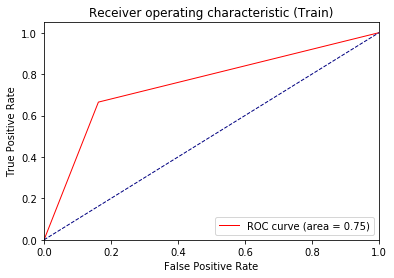

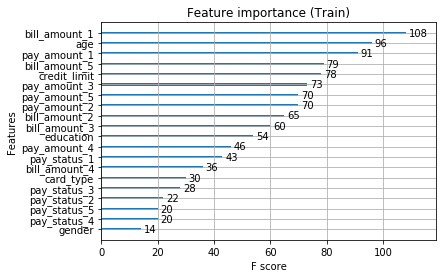

In [42]:

target = 'Default'
predictors = [x for x in df_train.columns if x not in [target]]

#Setup the XGBoost Classifier Object and define some default values for the hyperparameters
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,verbosity = 0)

#Fit the XGBoost model using 10-fold cross validation and return the model parameters
xgb1_model_params = modelbuild(xgb1, df_train, predictors)
n_estimators = xgb1_model_params.get('n_estimators')

#### Hyperparameter Tuning for Tree Specific Parameters

Use the n_estimators obtained in the previous step and tune other hyperparameters with regards to tree depth, min_child_weight, gamma(loss reduction) and sampling procedures

##### Hyperparameter Tuning for max_depth and min_child_weight
 - We use the GridSearch Algorithm to hit different possible combinations for these parameters. We start off with a potential list of hyperparameter values. We try to base this off the default values for the Classifier.
 - We look at the mean_test_scores of the 10 fold cross validation.
 - We want to pick a combination of the max_depth and min_child_weight which doesn't add too much complexity to the model.
 - We try to keep the max_depth small to reduce complexity and overfitting.
 - We use balanced accuracy in scoring the Grid Search

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed:    1.8s
[Parallel(n_jobs=3)]: Done  92 tasks      | elapsed:    5.9s
[Parallel(n_jobs=3)]: Done 120 out of 120 | elapsed:    8.0s finished



Model Report
Accuracy (Train): 0.7230609828300769
AUC Score (Train): 0.723060982830077
F1 Score (Train): 0.6899751449875725
Matthews Correlation Coefficient (Train): 0.45664479939750857
Balanced Accuracy Score (Train): 0.7230609828300769
Confusion Matrix (Train):
Prediction     0     1
Actual                
0           2803   575
1           1296  2082
Classification Report (Train):
              precision    recall  f1-score   support

           0       0.68      0.83      0.75      3378
           1       0.78      0.62      0.69      3378

    accuracy                           0.72      6756
   macro avg       0.73      0.72      0.72      6756
weighted avg       0.73      0.72      0.72      6756


Model Parameters:{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 43, 'n_jobs': 1, 'nthread':

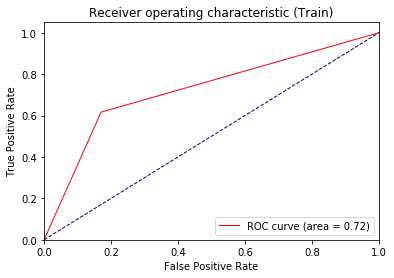

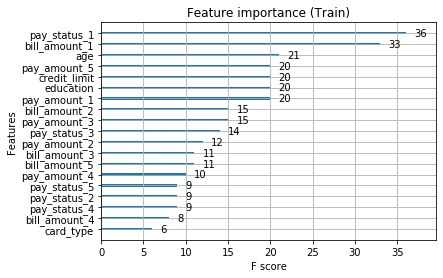

In [43]:
#Use broad ranges for the parameters like max_depth and min_child_weight while keeping the other parameters constant to keep the exhaustive Grid search to a minimum

param_test_xgb2 = {
 'max_depth':range(2,6,1),
 'min_child_weight':range(1,6,2)
}
xgb2 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=n_estimators,
gamma=0, subsample=0.8, colsample_bytree=0.8,
objective= 'binary:logistic', nthread=3, scale_pos_weight=1), 
param_grid = param_test_xgb2, scoring='balanced_accuracy',iid=False, cv=10,verbose =4,n_jobs=3)

xgb2_model_params = modelbuild(xgb2, df_train, predictors,False)


The best parameters obtained in the Grid Search were a max_depth = 5 and min_child_weight = 1

In [44]:
#A deep dive into the CV results to see which combination of hyperparamters offer a big jump in the mean_test_score (auc)

cv_results = {}
cv_results['params'] = xgb2.cv_results_.get('params')
cv_results['mean_test_score'] = xgb2.cv_results_.get('mean_test_score')
df_xgb2_results = pd.DataFrame.from_dict(cv_results)
df_xgb2_results.sort_values(by =['mean_test_score'],inplace=True,ascending=False)
df_xgb2_results

,params,mean_test_score
3,"{'max_depth': 3, 'min_child_weight': 1}",0.707807
6,"{'max_depth': 4, 'min_child_weight': 1}",0.706621
5,"{'max_depth': 3, 'min_child_weight': 5}",0.706474
4,"{'max_depth': 3, 'min_child_weight': 3}",0.706473
7,"{'max_depth': 4, 'min_child_weight': 3}",0.705587
1,"{'max_depth': 2, 'min_child_weight': 3}",0.705437
2,"{'max_depth': 2, 'min_child_weight': 5}",0.705289
9,"{'max_depth': 5, 'min_child_weight': 1}",0.705140
10,"{'max_depth': 5, 'min_child_weight': 3}",0.704401
0,"{'max_depth': 2, 'min_child_weight': 1}",0.704104


##### Hyperparamter Tuning for Gamma (Loss Reduction)

So far in the process we have identified the number of estimators (ballpark), max_depth, min_child_weight. We move on to the Gamma parameter which is a regualrization parameter in the sense that a larger value will make the algorithm more conservative. We cycle through different parameter options using a Grid Search. We start with the default value of 0.

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  32 tasks      | elapsed:    1.9s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    2.8s finished



Model Report
Accuracy (Train): 0.7230609828300769
AUC Score (Train): 0.723060982830077
F1 Score (Train): 0.6899751449875725
Matthews Correlation Coefficient (Train): 0.45664479939750857
Balanced Accuracy Score (Train): 0.7230609828300769
Confusion Matrix (Train):
Prediction     0     1
Actual                
0           2803   575
1           1296  2082
Classification Report (Train):
              precision    recall  f1-score   support

           0       0.68      0.83      0.75      3378
           1       0.78      0.62      0.69      3378

    accuracy                           0.72      6756
   macro avg       0.73      0.72      0.72      6756
weighted avg       0.73      0.72      0.72      6756


Model Parameters:{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.8, 'gamma': 0.0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 43, 'n_jobs': 1, 'nthread

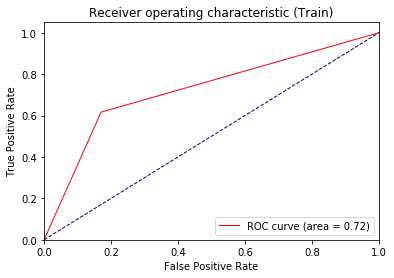

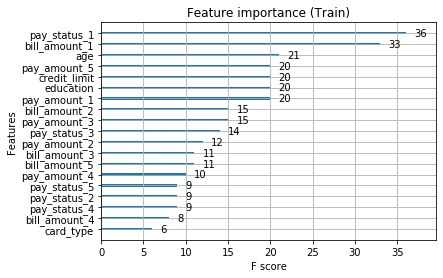

In [45]:
param_test_xgb3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
xgb3 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=n_estimators,
min_child_weight = 1,max_depth = 3, subsample=0.8, colsample_bytree=0.8,
objective= 'binary:logistic', nthread=3, scale_pos_weight=1), 
param_grid = param_test_xgb3, scoring='balanced_accuracy',iid=False, cv=10,verbose =4,n_jobs=3)
xgb3_model_params = modelbuild(xgb3, df_train, predictors,False)


Looking into the Cross Validation results for the Gamma Parameter. We use the gamma parameter of 0.1 based on the mean_test_score

In [46]:
#Looking into the CV results for the gamma parameter

cv_results = {}
cv_results['params'] = xgb3.cv_results_.get('params')
cv_results['mean_test_score'] = xgb3.cv_results_.get('mean_test_score')
df_xgb3_results = pd.DataFrame.from_dict(cv_results)
df_xgb3_results.sort_values(by =['mean_test_score'],inplace=True,ascending=False)
df_xgb3_results

,params,mean_test_score
0,{'gamma': 0.0},0.707807
1,{'gamma': 0.1},0.707807
2,{'gamma': 0.2},0.707807
3,{'gamma': 0.3},0.707807
4,{'gamma': 0.4},0.707807


#### Recalibration of Number of Estimators

Now that we have settled on the values of the following hyperparameters (min_child_weight,max_depth,gamma) we proceed to re-calibrate the number of estimators to be used.


Model Report
Accuracy (Train): 0.7386027235050325
AUC Score (Train): 0.7386027235050326
F1 Score (Train): 0.7149774047772757
Matthews Correlation Coefficient (Train): 0.4839011867277785
Balanced Accuracy Score (Train): 0.7386027235050325
Confusion Matrix (Train):
Prediction     0     1
Actual                
0           2775   603
1           1163  2215
Classification Report (Train):
              precision    recall  f1-score   support

           0       0.70      0.82      0.76      3378
           1       0.79      0.66      0.71      3378

    accuracy                           0.74      6756
   macro avg       0.75      0.74      0.74      6756
weighted avg       0.75      0.74      0.74      6756


Model Parameters:{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 102, 'nthread': 4, 'objecti

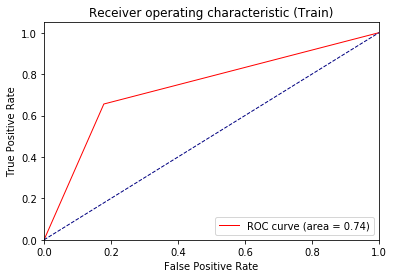

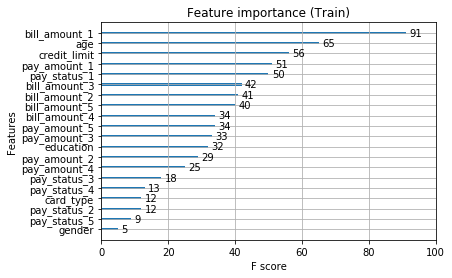

In [47]:
#Re-Calibrate the number of estimators once again

xgb4 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,verbosity = 0)

#Fit the XGBoost model using 10-fold cross validation and return the model parameters
xgb4_model_params = modelbuild(xgb4, df_train, predictors)
n_estimators = xgb4_model_params.get('n_estimators')

##### Hyperparameter Tuning for the Regularization Parameter

 We can also use the L1 regularization to combat overfitting

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed:    2.6s
[Parallel(n_jobs=3)]: Done  60 out of  60 | elapsed:    7.7s finished



Model Report
Accuracy (Train): 0.7378626406157489
AUC Score (Train): 0.7378626406157489
F1 Score (Train): 0.7131983805668016
Matthews Correlation Coefficient (Train): 0.4829218911673997
Balanced Accuracy Score (Train): 0.7378626406157489
Confusion Matrix (Train):
Prediction     0     1
Actual                
0           2783   595
1           1176  2202
Classification Report (Train):
              precision    recall  f1-score   support

           0       0.70      0.82      0.76      3378
           1       0.79      0.65      0.71      3378

    accuracy                           0.74      6756
   macro avg       0.75      0.74      0.74      6756
weighted avg       0.75      0.74      0.74      6756


Model Parameters:{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 102, 'n_jobs': 1, 'nthread'

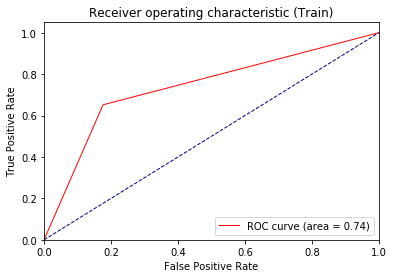

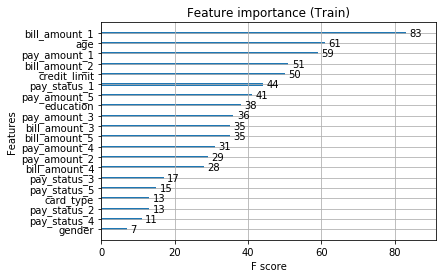

In [49]:
param_test_xgb5 = {
 'reg_alpha':[1e-5, 1e-3, 0.01, 0.1, 0.5,0]
}
xgb5 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=n_estimators,
min_child_weight = 1,max_depth = 3, subsample=0.8, colsample_bytree=0.8,gamma=0,
objective= 'binary:logistic', nthread=3, scale_pos_weight=1), 
param_grid = param_test_xgb5, scoring='balanced_accuracy',iid=False, cv=10,verbose =4,n_jobs=3)
xgb5_model_params = modelbuild(xgb5, df_train, predictors,False)

Looking into the Cross Validation results, we see that the reg_aplha value of 0.5 has the best mean_test_score

In [50]:
#Looking into the CV results for the reg_alpha parameter

cv_results = {}
cv_results['params'] = xgb5.cv_results_.get('params')
cv_results['mean_test_score'] = xgb5.cv_results_.get('mean_test_score')
df_xgb5_results = pd.DataFrame.from_dict(cv_results)
df_xgb5_results.sort_values(by =['mean_test_score'],inplace=True,ascending=False)
df_xgb5_results

,params,mean_test_score
4,{'reg_alpha': 0.5},0.709730
2,{'reg_alpha': 0.01},0.708545
1,{'reg_alpha': 0.001},0.708103
0,{'reg_alpha': 1e-05},0.707955
5,{'reg_alpha': 0},0.707955
3,{'reg_alpha': 0.1},0.707363


##### Reducing the Learning rate to see if we can build a better model

Now that we have identified the hyperparameters for the model, we reduce the learning rate and build the model.


Model Report
Accuracy (Train): 0.7309058614564832
AUC Score (Train): 0.7309058614564832
F1 Score (Train): 0.7031352057478774
Matthews Correlation Coefficient (Train): 0.47011287521934336
Balanced Accuracy Score (Train): 0.7309058614564832
Confusion Matrix (Train):
Prediction     0     1
Actual                
0           2785   593
1           1225  2153
Classification Report (Train):
              precision    recall  f1-score   support

           0       0.69      0.82      0.75      3378
           1       0.78      0.64      0.70      3378

    accuracy                           0.73      6756
   macro avg       0.74      0.73      0.73      6756
weighted avg       0.74      0.73      0.73      6756


Model Parameters:{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 715, 'nthread': 4, 'objec

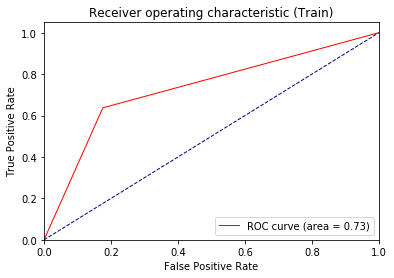

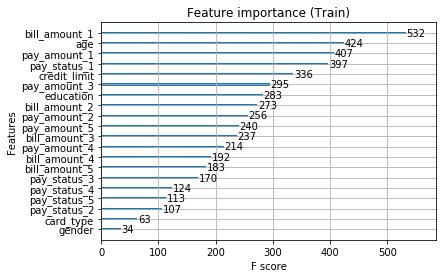

In [51]:
xgb6 = XGBClassifier(
 learning_rate =0.01,
 n_estimators= 1000,
 max_depth=3,
 min_child_weight=1,
 reg_alpha = 0.5,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1)

#Fit the XGBoost model using 5-fold cross validation and return the model parameters
xgb6_model_params = modelbuild(xgb6, df_train, predictors)

## Model Performance Evaluation on Independent Test Set

Here we look at how each model in the model building process scores against the independent test set. We pick the best model out of the lot for interpretability analysis. We look at Matthews Correlation Coefficient (<b>known to be a good metric to evaluate unbalanced datasets</b>), balanced error and f1 scores. We can use the custom_predict function and define the probability threshold based on the precision/recall tradeoff. Domain knowledge required to consider the following scenarios:

 - Are we okay with false positives if that means we are more likely to catch a default activity when it occurs ?
 ### OR
 - Are we okay with letting default activities go if we can avoid false positives ?

Which of these scenarios has a greater business impact. Based on this the threshold value can be set for the custom_predict function in production

Model: 1


Model Report
Accuracy (Test): 0.7634
AUC Score (Test): 0.7150220855711575
F1 Score (Test): 0.5441233140655106
Matthews Correlation Coefficient (Test): 0.39436858514264855
Balanced Accuracy Score (Test): 0.7150220855711575
Confusion Matrix (Test):
Prediction     0    1
Actual               
0           3111  763
1            420  706
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.88      0.80      0.84      3874
           1       0.48      0.63      0.54      1126

    accuracy                           0.76      5000
   macro avg       0.68      0.72      0.69      5000
weighted avg       0.79      0.76      0.77      5000


Model Parameters:{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 43, 'nthread': 4, 'objective': 'binary:

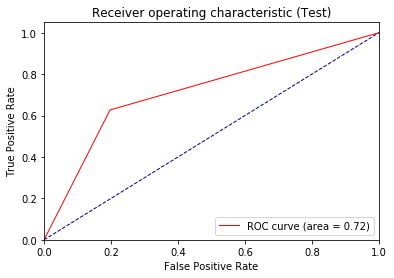



Model: 2


Model Report
Accuracy (Test): 0.7654
AUC Score (Test): 0.7068632161763398
F1 Score (Test): 0.5354455445544556
Matthews Correlation Coefficient (Test): 0.3849832670609408
Balanced Accuracy Score (Test): 0.7068632161763397
Confusion Matrix (Test):
Prediction     0    1
Actual               
0           3151  723
1            450  676
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.88      0.81      0.84      3874
           1       0.48      0.60      0.54      1126

    accuracy                           0.77      5000
   macro avg       0.68      0.71      0.69      5000
weighted avg       0.79      0.77      0.77      5000


Model Parameters:{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 43, 'n_jobs': 1, 'nthread': 3, 'object

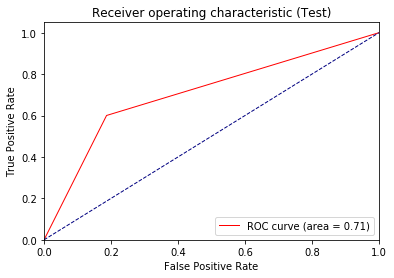



Model: 3


Model Report
Accuracy (Test): 0.7654
AUC Score (Test): 0.7068632161763398
F1 Score (Test): 0.5354455445544556
Matthews Correlation Coefficient (Test): 0.3849832670609408
Balanced Accuracy Score (Test): 0.7068632161763397
Confusion Matrix (Test):
Prediction     0    1
Actual               
0           3151  723
1            450  676
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.88      0.81      0.84      3874
           1       0.48      0.60      0.54      1126

    accuracy                           0.77      5000
   macro avg       0.68      0.71      0.69      5000
weighted avg       0.79      0.77      0.77      5000


Model Parameters:{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.8, 'gamma': 0.0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 43, 'n_jobs': 1, 'nthread': 3, 'obje

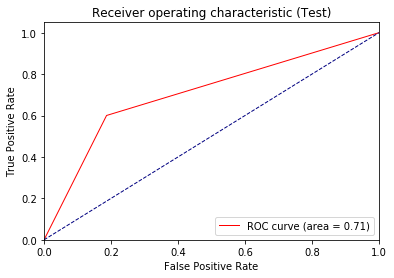



Model: 4


Model Report
Accuracy (Test): 0.7594
AUC Score (Test): 0.7108658534236991
F1 Score (Test): 0.5381957773512477
Matthews Correlation Coefficient (Test): 0.38598298241575796
Balanced Accuracy Score (Test): 0.7108658534236991
Confusion Matrix (Test):
Prediction     0    1
Actual               
0           3096  778
1            425  701
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.88      0.80      0.84      3874
           1       0.47      0.62      0.54      1126

    accuracy                           0.76      5000
   macro avg       0.68      0.71      0.69      5000
weighted avg       0.79      0.76      0.77      5000


Model Parameters:{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 102, 'nthread': 4, 'objective': 'bina

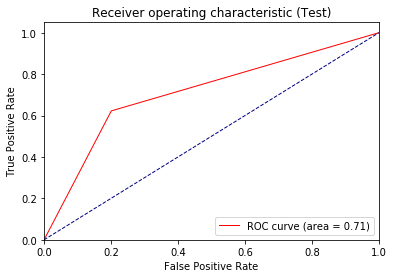



Model: 5


Model Report
Accuracy (Test): 0.7606
AUC Score (Test): 0.7100653259742272
F1 Score (Test): 0.5376593279258401
Matthews Correlation Coefficient (Test): 0.3857391138828971
Balanced Accuracy Score (Test): 0.7100653259742272
Confusion Matrix (Test):
Prediction     0    1
Actual               
0           3107  767
1            430  696
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.88      0.80      0.84      3874
           1       0.48      0.62      0.54      1126

    accuracy                           0.76      5000
   macro avg       0.68      0.71      0.69      5000
weighted avg       0.79      0.76      0.77      5000


Model Parameters:{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 102, 'n_jobs': 1, 'nthread': 3, 'objec

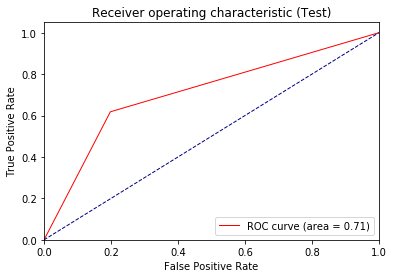



Model: 6


Model Report
Accuracy (Test): 0.7636
AUC Score (Test): 0.7088514677712051
F1 Score (Test): 0.5371965544244323
Matthews Correlation Coefficient (Test): 0.38627508969304264
Balanced Accuracy Score (Test): 0.708851467771205
Confusion Matrix (Test):
Prediction     0    1
Actual               
0           3132  742
1            440  686
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.88      0.81      0.84      3874
           1       0.48      0.61      0.54      1126

    accuracy                           0.76      5000
   macro avg       0.68      0.71      0.69      5000
weighted avg       0.79      0.76      0.77      5000


Model Parameters:{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 715, 'nthread': 4, 'objective': 'bina

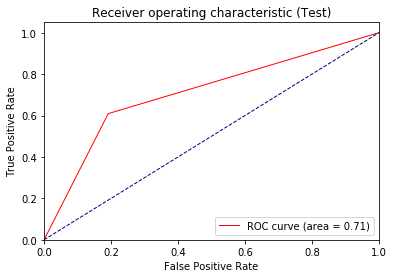

In [52]:
#Prediction on independent test set:

xgmodels = [xgb1,xgb2,xgb3,xgb4,xgb5,xgb6]


i = 1
for model in xgmodels:
    probabilities= model.predict_proba(df_test[predictors])[:,1]
    #Use custom predictfunction and define probability threshold on what is best for the application with regards to precision/recall
    test_predictions_custom =custom_predict(probabilities,threshold=0.5)
    if model in [xgb1,xgb4,xgb6]:
        type = 'nongrid'
    else:
        type ='grid'
        model = model.best_estimator_
    #Print the model report (Performance Metrics and Model Parameters)
    print("Model: "+str(i)+'\n')
    model_report(df_test['Default'], test_predictions_custom,model,'Test',type)
    print("\n")
    plot_roc(df_test['Default'], test_predictions_custom,'Test')
    print("\n")
    i+=1


Based on the metrics evaulated we see that Model 6 seems to be the best out of the lot on an independent test set. Using this model we can proceed with the interpretability analysis.

## Interpretability Analysis


 - Feature Importances native to XGBoost
 - Explaining Model Decisions with ELI5
 - Permuation Importances with ELI5
 

#### Feature Importances

We start off by plotting the feature importances using the XGBoost object. Using different importance types we get highly variable results. The important factors are not consistent across the board hence we need to look at other more consistent ways of presenting the important factors

Text(0.5, 1.0, 'Feature Importance with Split Mean Gain')

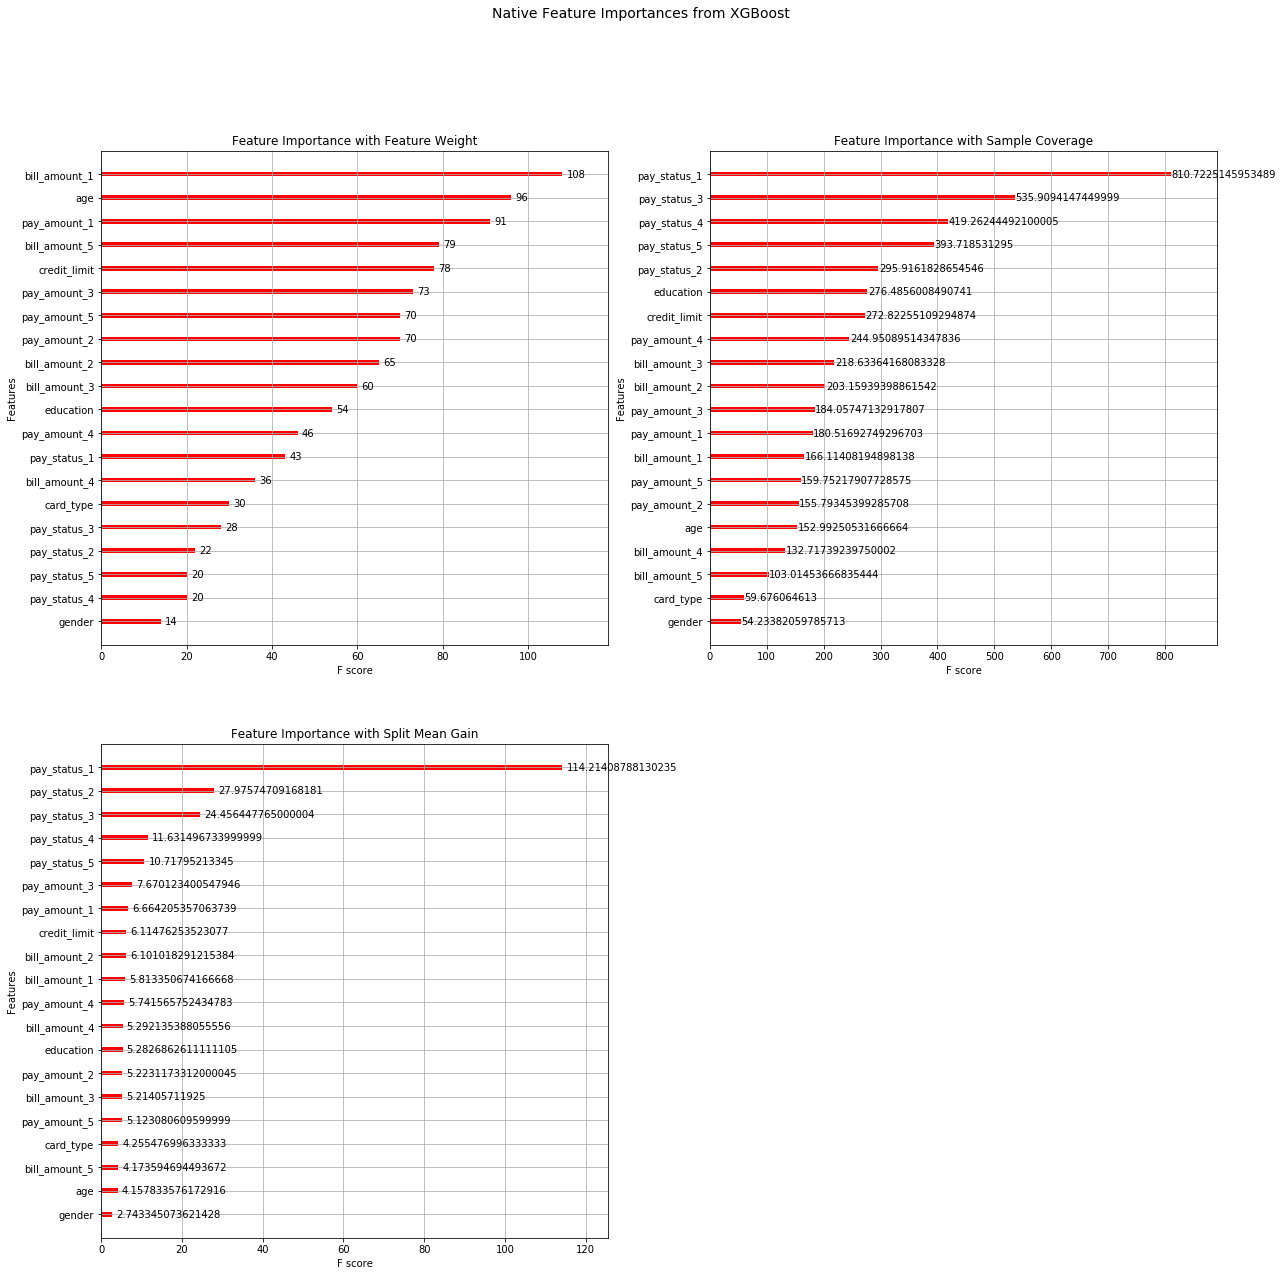

In [57]:
# ploting XGBoost default feature importances
fig = plt.figure(figsize = (20, 20))
title = fig.suptitle("Native Feature Importances from XGBoost", fontsize=14)

ax1 = fig.add_subplot(2, 2, 1)
plot_importance(xgb1, importance_type='weight', ax=ax1, color='red')
ax1.set_title("Feature Importance with Feature Weight")

ax2 = fig.add_subplot(2, 2, 2)
plot_importance(xgb1, importance_type='cover', ax=ax2, color='red')
ax2.set_title("Feature Importance with Sample Coverage")

ax3 = fig.add_subplot(2, 2, 3)
plot_importance(xgb1, importance_type='gain', ax=ax3, color='red')
ax3.set_title("Feature Importance with Split Mean Gain")

#### Permuation Importances with ELI5
Permuation Importances are known to be more consistent in explaining the factors that are important in the model as opposed to regular importances. The important features seem to have some similarity with the Important Features obtained using the sample coverage and gain criteria above. The pay status features have greater impact on the classification when permuted.

In [58]:
perm = PermutationImportance(xgb1).fit(df_test[predictors],df_test['Default'])
feature_names = list(df_test[predictors].columns)
eli5.show_weights(perm,feature_names =feature_names )

Weight,Feature
0.0725 ± 0.0070,pay_status_1
0.0392 ± 0.0064,pay_status_3
0.0141 ± 0.0049,bill_amount_3
0.0120 ± 0.0043,pay_status_4
0.0095 ± 0.0035,credit_limit
0.0064 ± 0.0026,pay_status_5
0.0038 ± 0.0031,bill_amount_2
0.0035 ± 0.0034,pay_status_2
0.0018 ± 0.0021,pay_amount_2
0.0016 ± 0.0017,card_type


#### Explaining Model Predictions with ELI5
Model can be presented as a sum of feature contributions (plus the bias), showing how the features lead to a particular prediction. ELI5 does it by showing weights for each feature depicting how influential it might have been in contributing to the final prediction decision across the trees. We try to find the factors that played a role in the best default and non-default prediction by the model.

##### Predicting when a particular customer will not default
In a successful prediction of non-default, the pay_status_1 the credit_limit and pay_amount_2 have an inverse impact on the customer being a non-defaulter. The strongest inverse impact is seen by pay_status_1, the higher the pay_status_1 (higher = more delay) the more likely the person will default. 

In [59]:
#Find the non-default prediction the model got right where the prediction probability is the lowest
df_concat =pd.DataFrame(pd.np.column_stack([df_test['Default'],test_predictions_custom,probabilities]),columns=['values','predictions','prob'])
df_concat = df_concat[(df_concat['values']==df_concat['predictions']) & (df_concat['values']==0)]
nd= df_concat['prob'].idxmin()
print('Reference:', df_test['Default'].iloc[nd])
print('Predicted:', test_predictions_custom[nd])
eli5.show_prediction(xgb1.get_booster(), df_test[predictors].iloc[nd], feature_names=feature_names, show_feature_values=True)

Reference: 0
Predicted: 0


##### Predicting when a particular customer will default
In a successful prediction of default, pay status features play an important role. Pay_status_1 (as in the payment status of the month prior) makes a positive impact on the whether the customer will default or not. The higher the number the more likely the customer will default

In [60]:
#Find the default prediction the model got right where the prediction probability was the highest
df_concat =pd.DataFrame(pd.np.column_stack([df_test['Default'],test_predictions_custom,probabilities]),columns=['values','predictions','prob'])
df_concat = df_concat[(df_concat['values']==df_concat['predictions']) & (df_concat['values']==1)]
d= df_concat['prob'].idxmax()
print('Reference:', df_test['Default'].iloc[d])
print('Predicted:', test_predictions_custom[d])
eli5.show_prediction(xgb1.get_booster(), df_test[predictors].iloc[d], feature_names=feature_names, show_feature_values=True)

Reference: 1
Predicted: 1
